<a href="https://colab.research.google.com/github/ConanOReilly/Final_Year_Project/blob/main/XAI/MAFSwinTinyFrozenFocalLossXAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Libraries**

In [ ]:
!pip install -q shap grad-cam transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 72.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 67.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 57.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 68.7 MB/s e

In [ ]:
from transformers import Swinv2Model
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import shap
import numpy as np
from torchvision import transforms
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from PIL import Image
import os
from sklearn.preprocessing import StandardScaler
import cv2

# **Defining Model Classes**

In [ ]:
class ModalityAttentionFusion(nn.Module):
    def __init__(self, dim_img, dim_meta):
        super(ModalityAttentionFusion, self).__init__()
        self.attn_layer = nn.Sequential(
            nn.Linear(dim_img + dim_meta, 128),
            nn.ReLU(),
            nn.Linear(128, 2),
            nn.Softmax(dim=1)
        )

    def forward(self, img_feat, meta_feat):
        combined = torch.cat([img_feat, meta_feat], dim=1)
        attn_weights = self.attn_layer(combined)
        img_alpha = attn_weights[:, 0].unsqueeze(1)
        meta_alpha = attn_weights[:, 1].unsqueeze(1)
        return img_alpha * img_feat + meta_alpha * meta_feat

In [ ]:
class MultiModalSwinClassifier(nn.Module):
    def __init__(self, num_classes, metadata_dim):
        super().__init__()
        self.image_model = Swinv2Model.from_pretrained("microsoft/swinv2-tiny-patch4-window8-256")
        for param in self.image_model.parameters():
            param.requires_grad = False

        self.image_fc = nn.Sequential(
            nn.Linear(self.image_model.config.hidden_size, 128),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        self.metadata_fc = nn.Sequential(
            nn.Linear(metadata_dim, 64),
            nn.ReLU(),
            nn.LayerNorm(64),
            nn.Dropout(0.3),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 128)
        )

        self.fusion = ModalityAttentionFusion(128, 128)
        self.classifier = nn.Linear(128, num_classes)

    def forward(self, image, metadata, return_cam=False):
        image_features = self.image_model(image).pooler_output
        image_features = self.image_fc(image_features)

        metadata_features = self.metadata_fc(metadata)
        fused = self.fusion(image_features, metadata_features)

        logits = self.classifier(fused)
        if return_cam:
            return logits, image_features
        return logits

# **Defining Grad-CAM and SHAP Classes**

In [ ]:
class ManualGradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_handles = []

        self.hook_handles.append(self.target_layer.register_forward_hook(self.save_activation))
        self.hook_handles.append(self.target_layer.register_backward_hook(self.save_gradient))

    def save_activation(self, module, input, output):
        self.activations = output.detach()

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def remove_hooks(self):
        for handle in self.hook_handles:
            handle.remove()

    def __call__(self, image_tensor, metadata_tensor, class_idx):
        self.model.zero_grad()
        output, _ = self.model(image_tensor, metadata_tensor, return_cam=True)
        class_score = output[:, class_idx].squeeze()
        class_score.backward()

        pooled_grad = self.gradients.mean(dim=1, keepdim=True)
        cam = (pooled_grad * self.activations).sum(dim=2).squeeze()
        cam = torch.clamp(cam, min=0).cpu().numpy()
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)

        return cam

In [ ]:
class MetadataOnlyModel(nn.Module):
    def __init__(self, metadata_fc, classifier):
        super().__init__()
        self.metadata_fc = metadata_fc
        self.classifier = classifier
        self.device = next(metadata_fc.parameters()).device

    def forward(self, x):
        x = torch.tensor(x, dtype=torch.float32).to(self.device)
        with torch.no_grad():
            features = self.metadata_fc(x)
            output = self.classifier(features)
        return output.cpu().numpy()

# **Loading Model and Data**

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultiModalSwinClassifier(num_classes=6, metadata_dim = 82).to(device)

model.load_state_dict(torch.load(
    "/content/drive/MyDrive/Final Year Project/Code/Hugging Face Models/WandB model/Model Paths/swin_tiny_maf_fl_25_epochs.pth",
    map_location=device
))
model.eval()
for p in model.parameters():
    p.requires_grad = True

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/69.9k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/113M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/113M [00:00<?, ?B/s]

In [ ]:
csv_path = "/content/drive/MyDrive/Final Year Project/Code/MetaBlock/Data/pad-ufes-20_parsed_test.csv"
img_dir = "/content/drive/MyDrive/Final Year Project/Data/PAD/imgs"
df = pd.read_csv(csv_path)

exclude_cols = ['img_id', 'diagnostic', 'patient_id', 'lesion_id', 'folder', 'diagnostic_number', 'label_encoded']
metadata_cols = [col for col in df.columns if col not in exclude_cols]

scaler = StandardScaler()
df[metadata_cols] = scaler.fit_transform(df[metadata_cols])

label_dict = {label: idx for idx, label in enumerate(sorted(df['diagnostic'].unique()))}
df["label_encoded"] = df["diagnostic"].map(label_dict)

class_samples = {}

# **Grad-CAM**

In [ ]:
for diag in df['diagnostic'].unique():
    row = df[df['diagnostic'] == diag].iloc[0]
    class_samples[diag] = row

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

target_layer = model.image_model.encoder.layers[0].blocks[0].output.dense

manual_cam = ManualGradCAM(model, target_layer)

for diag, row in class_samples.items():
    img_id = row["img_id"]
    image_path = os.path.join(img_dir, img_id)
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(device)

    meta_values = df[df["img_id"] == img_id][metadata_cols].values.astype(np.float32)
    meta_tensor = torch.tensor(meta_values).to(device)

    label = int(row["label_encoded"])

    cam_map = manual_cam(image_tensor, meta_tensor, class_idx=label)

    rgb = image_tensor.squeeze().permute(1, 2, 0).cpu().numpy()
    rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min())
    cam_map = cam_map.reshape(64, 64)
    cam_resized = cv2.resize(cam_map, (256, 256))
    cam_image = show_cam_on_image(rgb, cam_resized, use_rgb=True)

    plt.figure(figsize=(6, 6))
    plt.imshow(cam_image)
    plt.title(f"Manual Grad-CAM – {diag} (Label {label})")
    plt.axis("off")
    plt.show()

manual_cam.remove_hooks()

Output hidden; open in https://colab.research.google.com to view.

# **SHAP**


 SHAP Summary for Class: ACK


<ipython-input-11-415c0a2998e8>:8: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values[..., i], feature_names=metadata_cols, class_names=[name])


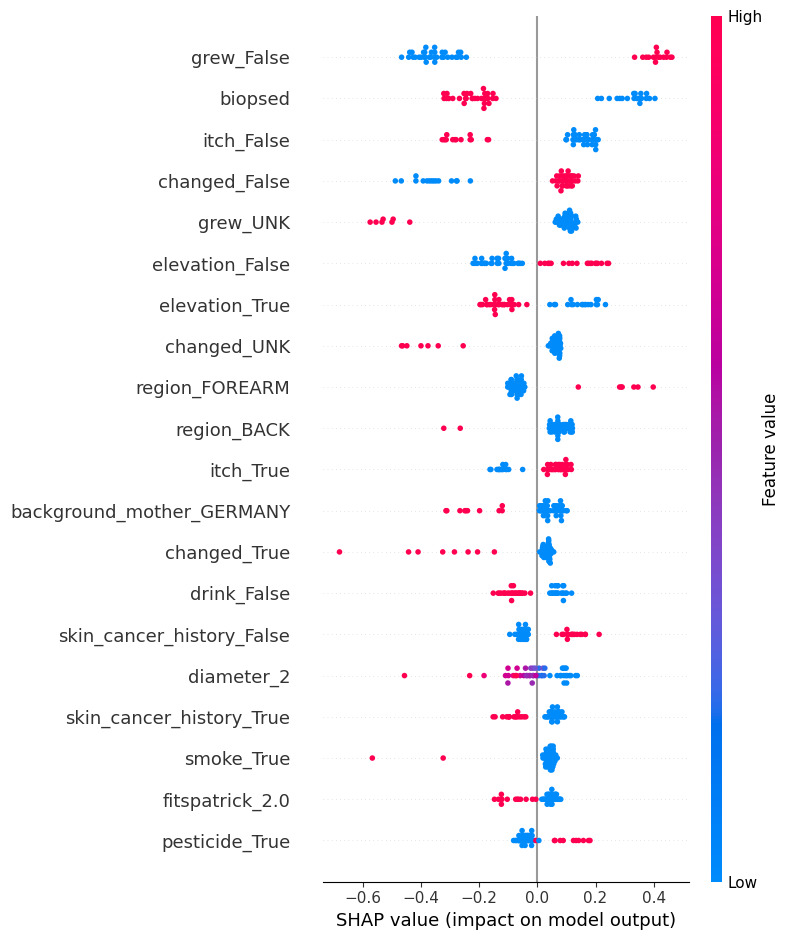


 SHAP Summary for Class: BCC


<ipython-input-11-415c0a2998e8>:8: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values[..., i], feature_names=metadata_cols, class_names=[name])


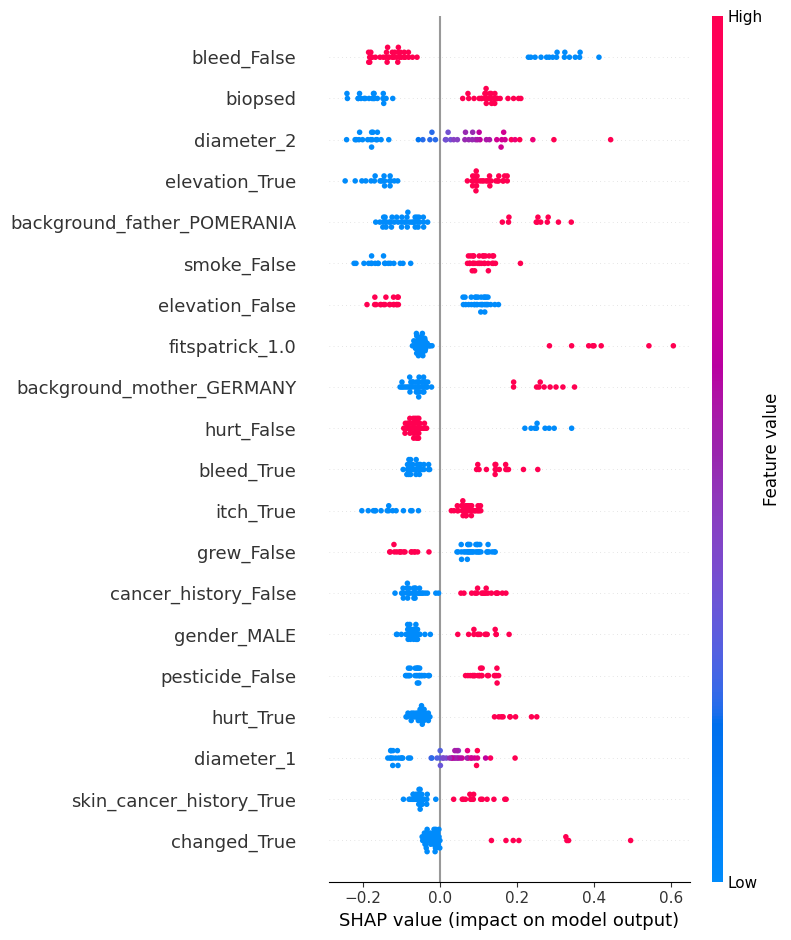


 SHAP Summary for Class: MEL


<ipython-input-11-415c0a2998e8>:8: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values[..., i], feature_names=metadata_cols, class_names=[name])


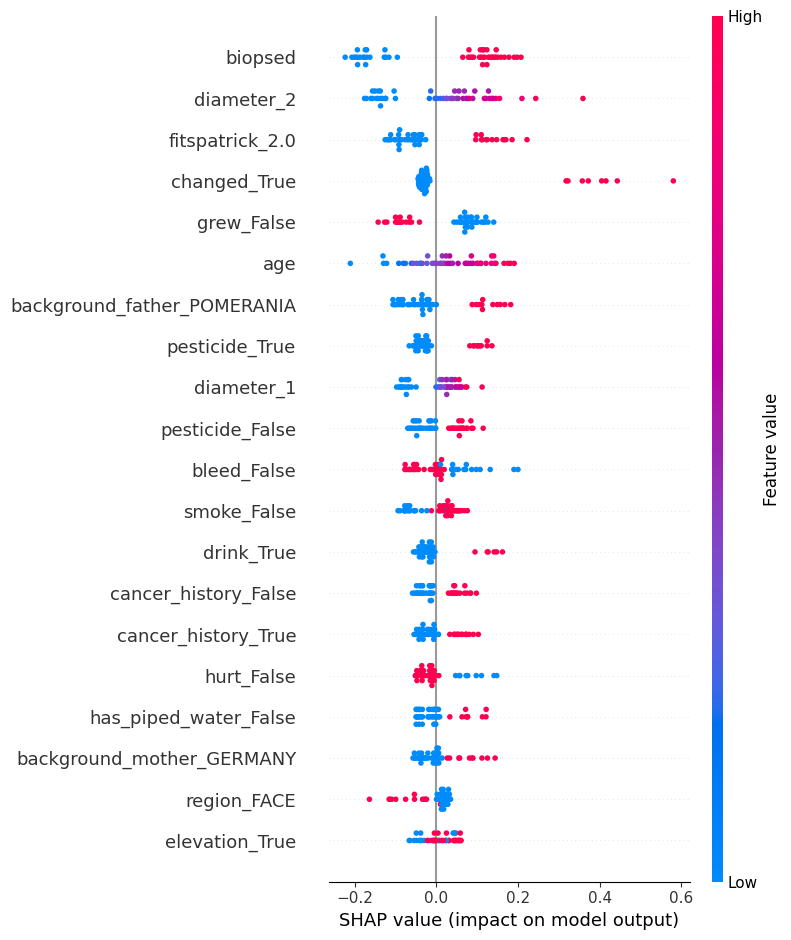


 SHAP Summary for Class: NEV


<ipython-input-11-415c0a2998e8>:8: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values[..., i], feature_names=metadata_cols, class_names=[name])


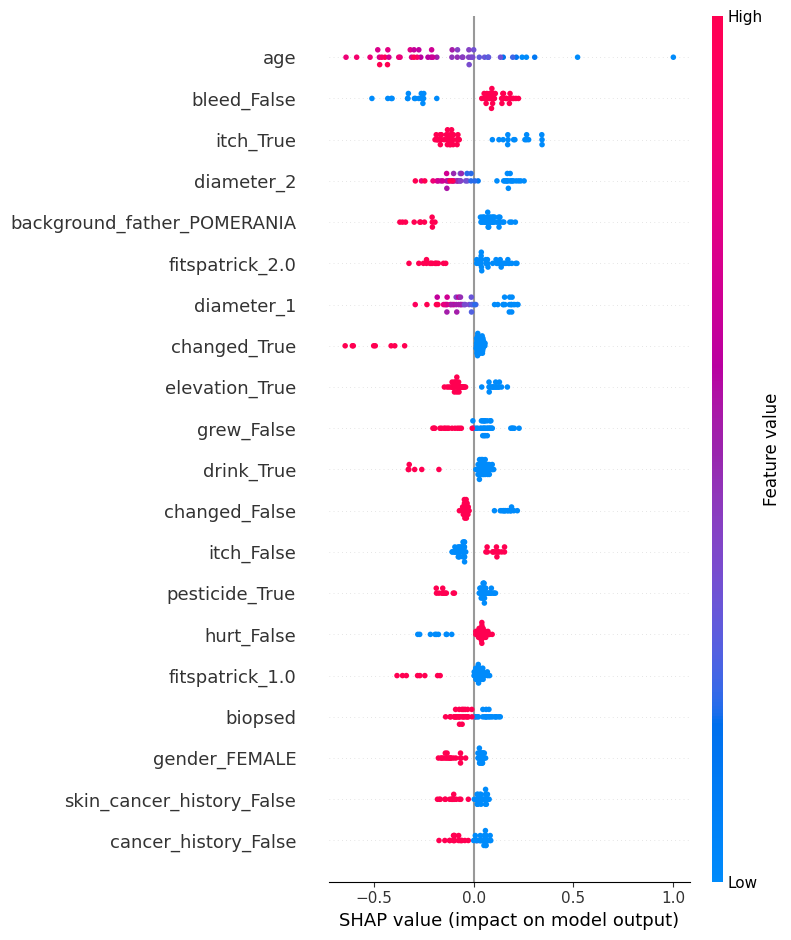


 SHAP Summary for Class: SCC


<ipython-input-11-415c0a2998e8>:8: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values[..., i], feature_names=metadata_cols, class_names=[name])


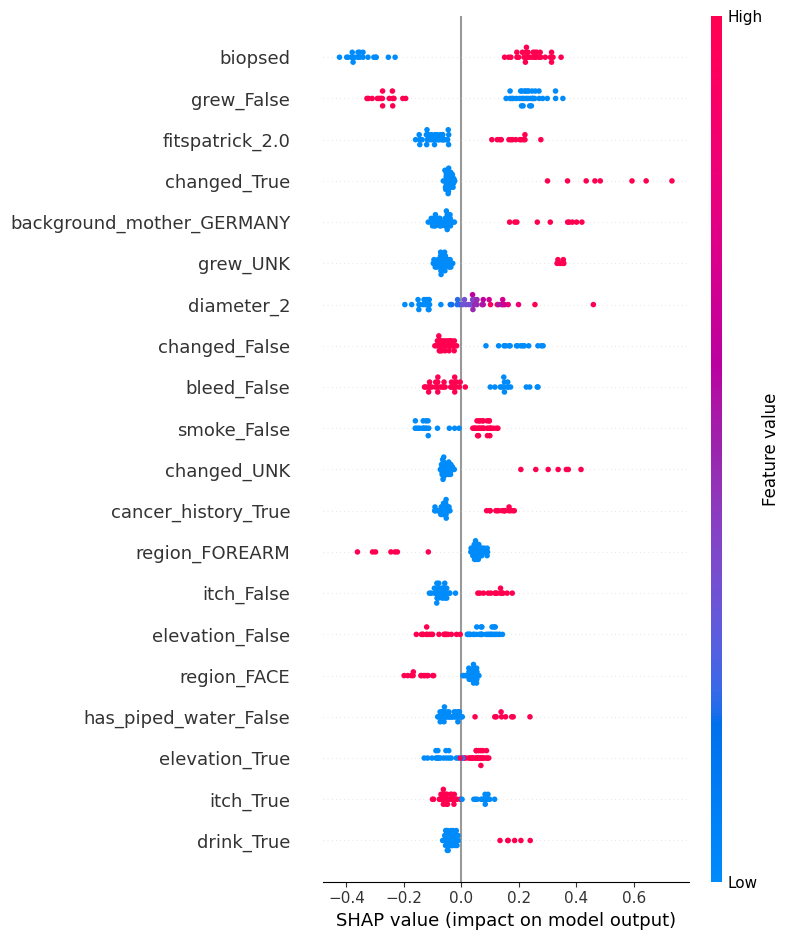


 SHAP Summary for Class: SEK


<ipython-input-11-415c0a2998e8>:8: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values[..., i], feature_names=metadata_cols, class_names=[name])


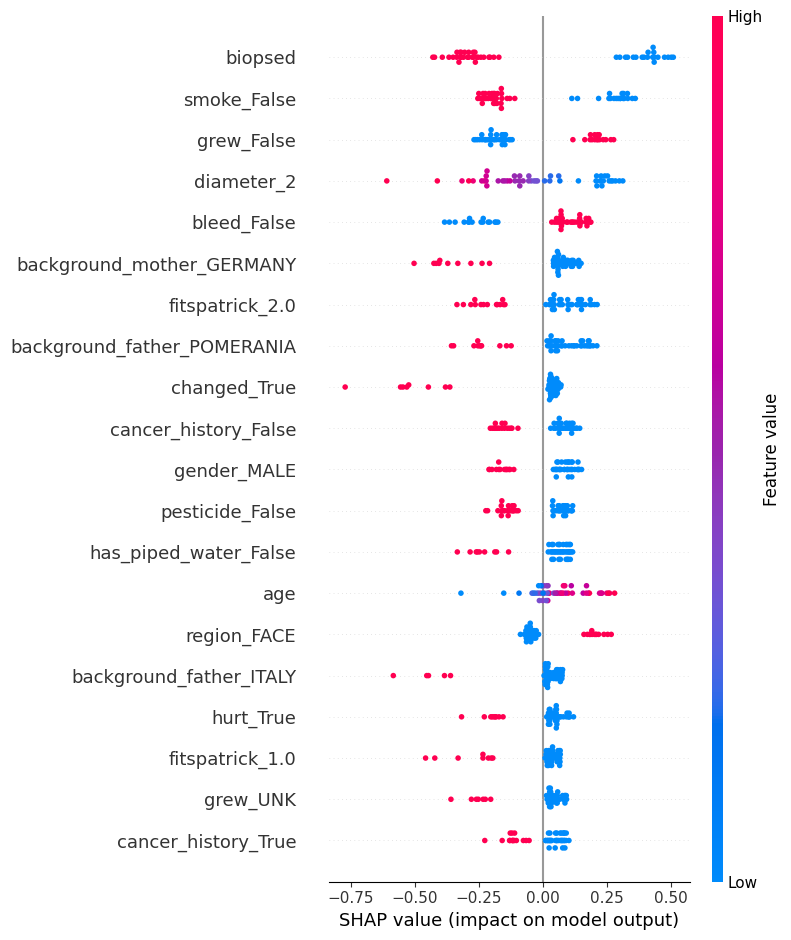

In [ ]:
X_test_meta = df[metadata_cols].values.astype(np.float32)
meta_model = MetadataOnlyModel(model.metadata_fc, model.classifier)
explainer = shap.Explainer(meta_model, shap.maskers.Independent(X_test_meta))
shap_values = explainer(X_test_meta[:50])
class_names = ["ACK", "BCC", "MEL", "NEV", "SCC", "SEK"]
for i, name in enumerate(class_names):
    print(f"\n SHAP Summary for Class: {name}")
    shap.summary_plot(shap_values[..., i], feature_names=metadata_cols, class_names=[name])